# World Cup 22' Predictor

### Alperen Özçelik

###  Introduction:

The World Cup is one of the most widely followed sports events in the world and predicting the winner has always been a topic of interest for many people. In this study, I aimed to use advanced machine learning techniques to analyze historical data and make predictions about the outcome of the tournament. The goal of this project is to predict the winner of the 2022 World Cup using various classification techniques, feature extraction methods, and datasets. 

Two datasets were used in this study. 
* The first dataset contains match scores from 1982 to present, including information about the teams, scores, and tournament stage. [1]
* The second dataset contains FIFA rank changes, which provides information about the overall performance of teams throughout the years. [2] 

By combining these datasets, I want to gain a better understanding of the performance of teams in the World Cup and their chances of winning the tournament.

I implemented various classification techniques such as logistic regression, decision trees, and neural networks, and feature extraction methods to analyze the data. In addition, I use various evaluation metrics such as accuracy, precision, recall, and F1 score to compare the performance of the models and select the best one.

The goal of this project is not only to predict the winner of the 2022 World Cup but also to provide an in-depth analysis of the performance of different teams and the factors that contribute to their success. By analyzing the historical data, I tried to gain insights that can help in understanding the dynamics of the tournament and the factors that influence the outcome.


#### Libraries

In [1]:
# !pip install scikit-plot
# !pip install lazypredict
# !pip install plotly
# !pip install tabulate
# !pip install pydot

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
import plotly.figure_factory as ff
import plotly.express as px
from IPython.display import Markdown as md
from IPython.display import display, Image, SVG, Math, YouTubeVideo

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import os
import plotly.graph_objs as go 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from numpy.ma.extras import row_stack
from itertools import combinations
from tabulate import tabulate
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

## 1) Preprocessing

The dataset was preprocessed to ensure that it was in the appropriate format for training and evaluating the model. This included tasks such as handling missing values, encoding categorical variables, and scaling numerical variables. These steps helped in improving the performance of the model and reducing the risk of overfitting. This helped in ensuring that the model was generalizable to new data

* Here, all parts up to the model selection actually include preprocessing, but I chose to number them this way to break the project apart.

#### Read 3 csv files and return them as dataframes


In [2]:
df =  pd.read_csv("/content/drive/MyDrive/WC22/dataset/match_results.csv")
rank = pd.read_csv('/content/drive/MyDrive/WC22/dataset/fifa_ranking-2022-10-06.csv')
world_cup = pd.read_csv("/content/drive/MyDrive/WC22/dataset/Fifa_Worldcup_2022_Groups.csv")

#### Check null values and drop

In [3]:
nulls_df = df.isnull().sum(axis=1)
print('Null values in df: ' + str(nulls_df.sum()))

nulls_rank = rank.isnull().sum(axis=1)
print('Null values in rank: ' + str(nulls_rank.sum()))

nulls_wc = world_cup.isnull().sum(axis=1)
print('Null values in world cup: ' + str(nulls_wc.sum()))

Null values in df: 2
Null values in rank: 0
Null values in world cup: 0


In [4]:
df = df.dropna()

#### The data I will use

In [5]:
# replace unmatched names
df = df.replace(['United States'], 'USA')
df = df.replace(['South Korea'], 'Korea Republic')

df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [6]:
rank.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,1,Germany,GER,57.0,0.0,0,UEFA,1992-12-31
1,96,Syria,SYR,11.0,0.0,0,AFC,1992-12-31
2,97,Burkina Faso,BFA,11.0,0.0,0,CAF,1992-12-31
3,99,Latvia,LVA,10.0,0.0,0,UEFA,1992-12-31
4,100,Burundi,BDI,10.0,0.0,0,CAF,1992-12-31


In [7]:
world_cup = world_cup.set_index('Team')
world_cup.head()

,Group,Flag_Image,Country_Name_Short,First match against,Second match against,Third match against
Team,,,,,,
Qatar,A,https://cloudinary.fifa.com/api/v3/picture/fla...,QAT,Ecuador,Senegal,Netherlands
Ecuador,A,https://cloudinary.fifa.com/api/v3/picture/fla...,ECU,Qatar,Netherlands,Senegal
Senegal,A,https://cloudinary.fifa.com/api/v3/picture/fla...,SEN,Netherlands,Qatar,Ecuador
Netherlands,A,https://cloudinary.fifa.com/api/v3/picture/fla...,NED,Senegal,Ecuador,Qatar
England,B,https://cloudinary.fifa.com/api/v3/picture/fla...,ENG,Iran,USA,Wales


In [8]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran")
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank_vis = rank.copy()

rank = rank[(rank["rank_date"] >= "2016-1-1")].reset_index(drop=True)
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

rank_vis = rank_vis[(rank_vis["rank_date"] >= "2020-1-1")].reset_index(drop=True).copy()
rank_vis = rank_vis.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index().copy()

#### Since very old matches will not affect the results much, I decided to use the matches after 2018. But since I will need the past matches in Feature Engineering part, I aimed to speed up the code by dividing the dataset from 2016 for now.

In [9]:
df["date"] = pd.to_datetime(df["date"])
df = df[(df["date"] >= "2016-1-1")].reset_index(drop=True)
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2016-01-03,India,Afghanistan,2.0,1.0,SAFF Cup,Thiruvananthapuram,India,False
1,2016-01-06,Rwanda,Cameroon,1.0,1.0,Friendly,Gisenyi,Rwanda,False
2,2016-01-06,Sweden,Estonia,1.0,1.0,Friendly,Abu Dhabi,United Arab Emirates,True
3,2016-01-08,Bangladesh,Sri Lanka,4.0,2.0,Friendly,Jessore,Bangladesh,False
4,2016-01-08,Trinidad and Tobago,Haiti,0.0,1.0,Copa América qualification,Panama City,Panama,True


## 2) Data Analysis and Visualization

The dataset used for training and evaluating the model was first explored using descriptive statistics and data visualization techniques. This allowed identifying patterns, trends, and outliers in the data. The data was also cleaned and transformed as necessary to improve the performance of the model. This step helped in understanding the distribution and relationships in the data, and enabled making better decisions for the model selection.

#### Points change of teams with the highest 10 FIFA Ranks in the last 2 years

In [10]:
ranking_df = pd.pivot_table(data = rank_vis, 
                            values = 'total_points',
                            index = 'country_full',
                            columns = 'rank_date').fillna(0.0)

best_ranks = ranking_df.loc[ranking_df['2022-10-06'].sort_values(ascending = False)[:10].index]
fig = go.Figure()

for i in range(len(best_ranks.values)):
    fig.add_trace(go.Scatter(x = best_ranks.columns, 
                             y = best_ranks.iloc[i],
                             name = best_ranks.index[i]))
    
fig.update_layout(
    title="Evolution of the FIFA Rankings",
    yaxis_title="Points"
)
fig.show(renderer="colab")

#### Match types since 2016

Text(0.5, 1.0, 'TOP 10 TYPE OF MATCHES')

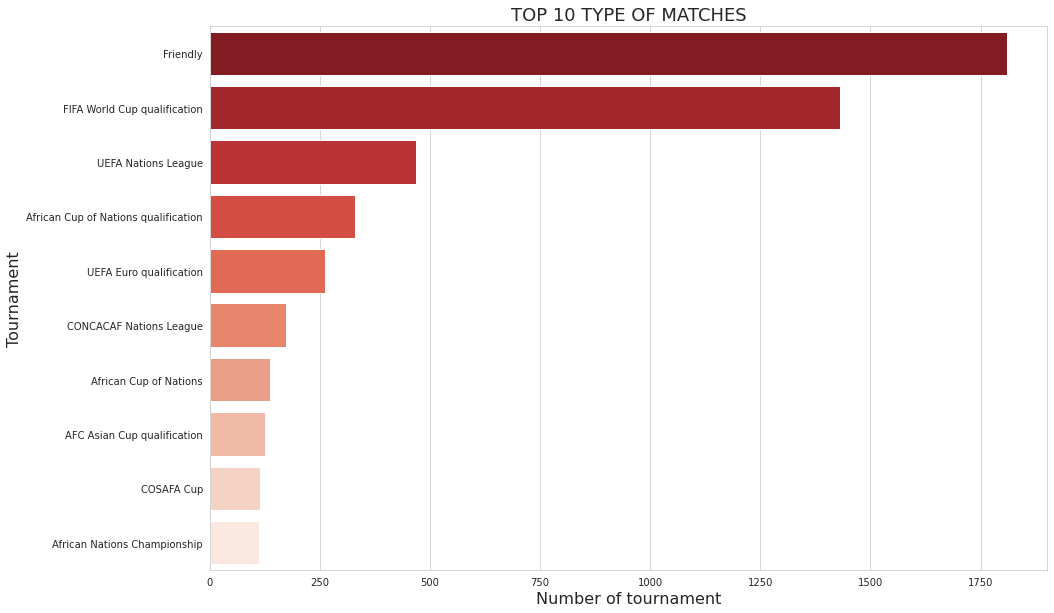

In [11]:
tournament = df['tournament'].value_counts()
tournament = tournament[:10]

plt.figure(figsize = (15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=tournament.index, x=tournament.values, palette="Reds_r", orient='h')
ax.set_ylabel('Tournament', size=16)
ax.set_xlabel('Number of tournament', size=16)
ax.set_title("TOP 10 TYPE OF MATCHES", fontsize=18)

#### I create a dataframe named country_info for charts

In [12]:
# create two dataframe for the home and away teams
home = df[['home_team', 'home_score']].rename(columns={'home_team':'team', 'home_score':'score'})
away = df[['away_team', 'away_score']].rename(columns={'away_team':'team', 'away_score':'score'})

# merge it into one
team_score = home.append(away).reset_index(drop=True)

# make an aggregation of the the score column group by the team
country_info = team_score.groupby('team')['score'].agg(['sum','count','mean']).reset_index()
country_info = country_info.rename(columns={'sum':'nb_goals', 'count':'nb_matches', 'mean':'goal_avg'})
country_info = country_info[(country_info["nb_matches"] > 50)].reset_index(drop=True)

In [13]:
country_info

,team,nb_goals,nb_matches,goal_avg
0,Albania,70.0,66,1.060606
1,Algeria,160.0,76,2.105263
2,Andorra,27.0,61,0.442623
3,Angola,54.0,55,0.981818
4,Argentina,151.0,80,1.887500
...,...,...,...,...
120,Venezuela,76.0,68,1.117647
121,Vietnam,95.0,57,1.666667
122,Wales,85.0,73,1.164384
123,Zambia,105.0,83,1.265060


#### Teams with the most goals per game since 2016

Text(0.5, 1.0, 'TEAMS WITH THE MOST GOALS PER MATCH')

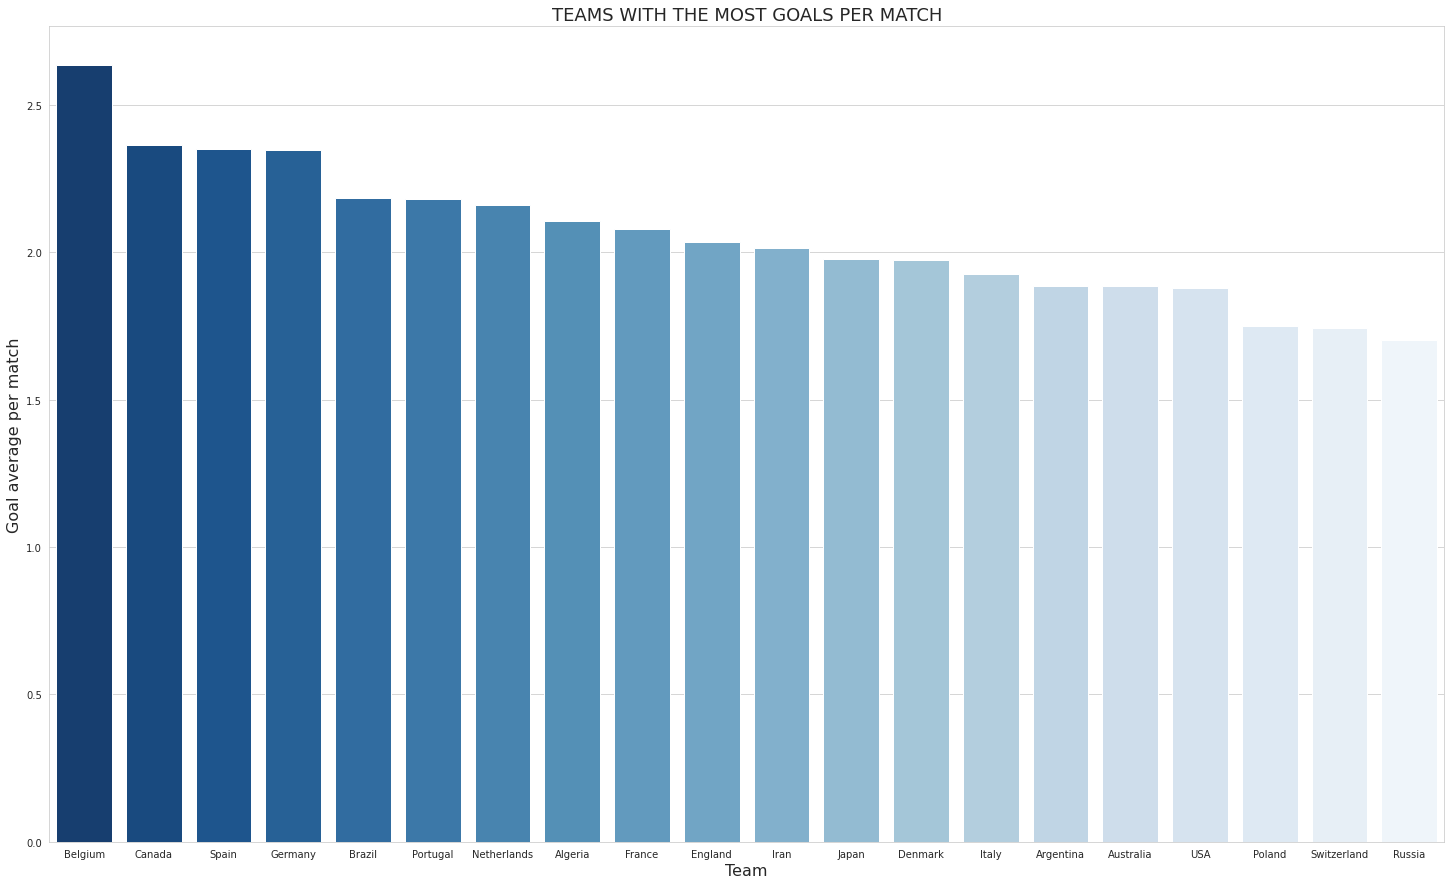

In [14]:
plt.figure(figsize = (25,15))
sns.set_style("whitegrid")
plt_data = country_info.sort_values(by='goal_avg', ascending=False)[:20]
ax = sns.barplot(x="team", y="goal_avg", data=plt_data, palette="Blues_r")
ax.set_xlabel('Team', size=16)
ax.set_ylabel('Goal average per match', size=16)
ax.set_title("TEAMS WITH THE MOST GOALS PER MATCH", fontsize=18)

#### Teams with the most goals in total since 2016

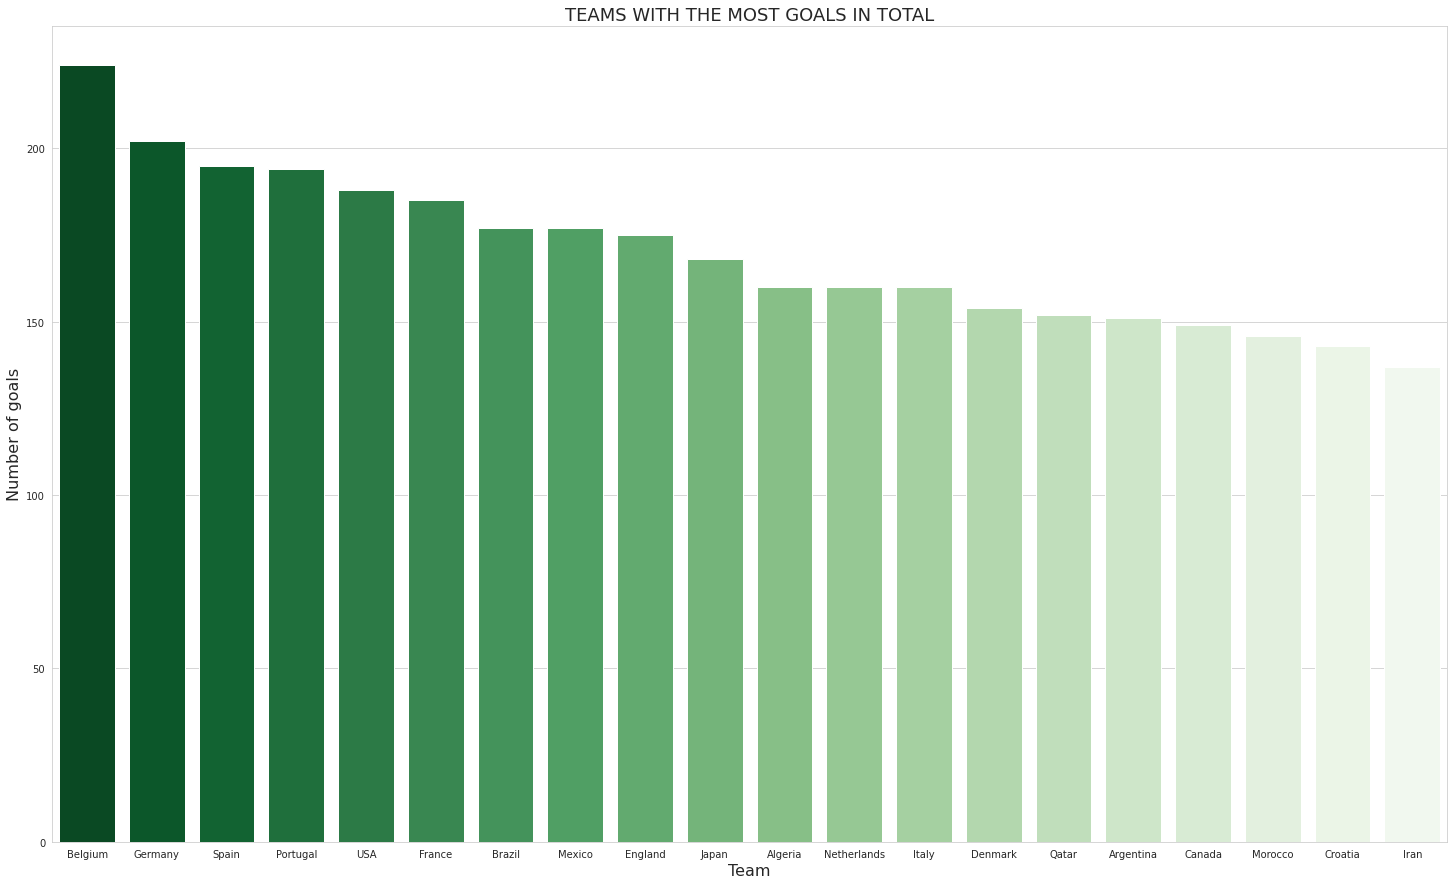

In [15]:
plt.figure(figsize = (25,15))
sns.set_style("whitegrid")
plt_data = country_info.sort_values(by='nb_goals', ascending=False)[:20]
ax = sns.barplot(x="team", y="nb_goals", data=plt_data, palette="Greens_r")
ax.set_xlabel('Team', size=16)
ax.set_ylabel('Number of goals', size=16)
ax.set_title("TEAMS WITH THE MOST GOALS IN TOTAL", fontsize=18)
del plt_data, country_info

## 3) Feature Engineering & More Preprocess

Feature engineering is the process of transforming raw data or features into new features that better represent the underlying problem to the predictive models. It involves selecting relevant features and creating new ones to improve the performance of machine learning algorithms. It is a crucial step in the process of building a successful machine learning model as it can have a significant impact on the accuracy and performance of the model.

#### I'm merging the dataframe with the ranks and the dataframe with the match results

In [16]:
#Join Ranking with match 
df = df.merge(rank, left_on=['date', 'home_team'], right_on=['rank_date', 'country_full'])
df = df.merge(rank, left_on=['date', 'away_team'], right_on=['rank_date', 'country_full'], suffixes=('_home', '_away')) 
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,rank_change_home,confederation_home,rank_date_away,rank_away,country_full_away,country_abrv_away,total_points_away,previous_points_away,rank_change_away,confederation_away
0,2016-01-08,Bangladesh,Sri Lanka,4.0,2.0,Friendly,Jessore,Bangladesh,False,2016-01-08,...,-3.0,AFC,2016-01-08,188.0,Sri Lanka,SRI,61.0,45.0,-6.0,AFC
1,2016-01-08,Trinidad and Tobago,Haiti,0.0,1.0,Copa América qualification,Panama City,Panama,True,2016-01-08,...,1.0,CONCACAF,2016-01-08,79.0,Haiti,HAI,453.0,467.0,2.0,CONCACAF
2,2016-01-08,Panama,Cuba,4.0,0.0,Copa América qualification,Panama City,Panama,False,2016-01-08,...,1.0,CONCACAF,2016-01-08,136.0,Cuba,CUB,259.0,377.0,45.0,CONCACAF
3,2016-01-10,Sweden,Finland,3.0,0.0,Friendly,Abu Dhabi,United Arab Emirates,True,2016-01-10,...,-1.0,UEFA,2016-01-10,44.0,Finland,FIN,663.0,663.0,1.0,UEFA
4,2016-01-11,Maldives,Cambodia,3.0,2.0,Friendly,Jessore,Bangladesh,True,2016-01-11,...,-3.0,AFC,2016-01-11,181.0,Cambodia,CAM,83.0,83.0,1.0,AFC


In [17]:
df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'rank_date_home',
       'rank_home', 'country_full_home', 'country_abrv_home',
       'total_points_home', 'previous_points_home', 'rank_change_home',
       'confederation_home', 'rank_date_away', 'rank_away',
       'country_full_away', 'country_abrv_away', 'total_points_away',
       'previous_points_away', 'rank_change_away', 'confederation_away'],
      dtype='object')

#### Drop unnecessary columns

In [18]:
df.drop(['city', 'country', 'neutral', 'rank_date_home', 'country_full_home', 'country_abrv_home', 'previous_points_home', 'rank_change_home',
       'confederation_home', 'rank_date_away',
       'country_full_away', 'country_abrv_away',
       'previous_points_away', 'rank_change_away', 'confederation_away'], inplace=True, axis=1)

df

,date,home_team,away_team,home_score,away_score,tournament,rank_home,total_points_home,rank_away,total_points_away
0,2016-01-08,Bangladesh,Sri Lanka,4.0,2.0,Friendly,179.0,87.00,188.0,61.00
1,2016-01-08,Trinidad and Tobago,Haiti,0.0,1.0,Copa América qualification,50.0,623.00,79.0,453.00
2,2016-01-08,Panama,Cuba,4.0,0.0,Copa América qualification,65.0,544.00,136.0,259.00
3,2016-01-10,Sweden,Finland,3.0,0.0,Friendly,34.0,771.00,44.0,663.00
4,2016-01-11,Maldives,Cambodia,3.0,2.0,Friendly,157.0,159.00,181.0,83.00
...,...,...,...,...,...,...,...,...,...,...
5221,2022-09-27,Albania,Iceland,1.0,1.0,UEFA Nations League,66.0,1361.81,63.0,1379.61
5222,2022-09-27,Norway,Serbia,0.0,2.0,UEFA Nations League,36.0,1488.57,25.0,1549.53
5223,2022-09-27,Sweden,Slovenia,1.0,1.0,UEFA Nations League,20.0,1563.44,65.0,1372.48
5224,2022-09-27,Kosovo,Cyprus,5.0,1.0,UEFA Nations League,106.0,1183.90,108.0,1180.52


#### Creating new features from rank difference, point difference and match type(friendly)

#### The strength of the teams they encounter is as important as the number of matches the teams have won, so I created these features.

#### At this stage, I tried to use the rank difference and point difference attributes in different ways, I made this because the feature that increases the accuracy the most is to divide the differences between the teams by the average.

#### Also I add winner column

In [19]:
df['rank_difference'] = df['rank_home'] - df['rank_away']
df['average_rank'] = (df['rank_home'] + df['rank_away'])/2
df['point_difference'] = df['total_points_home'] - df['total_points_away']
df['average_point'] = (df['total_points_home'] + df['total_points_away']) / 2

df['not_friendly'] = df['tournament'] != 'Friendly'
df['rank_diff/avg'] = df['rank_difference'] / df['average_rank']
df['point_diff/avg'] = df['point_difference'] / df['average_point']

# adding winning team column
winner = []
for i in range (len(df['home_team'])):
    if df['home_score'][i] > df['away_score'][i]:
        winner.append(1)
    elif df['home_score'][i] < df['away_score'][i]:
        winner.append(2)
    else:
        winner.append(0)
df['winning_team'] = winner
df_for_test = df.copy()

df.drop(['rank_difference', 'average_rank', 'point_difference', 'average_point', 'total_points_home', 'total_points_away', 'rank_home', 'rank_away', 'tournament'], inplace=True, axis=1)
df

,date,home_team,away_team,home_score,away_score,not_friendly,rank_diff/avg,point_diff/avg,winning_team
0,2016-01-08,Bangladesh,Sri Lanka,4.0,2.0,False,-0.049046,0.351351,1
1,2016-01-08,Trinidad and Tobago,Haiti,0.0,1.0,True,-0.449612,0.315985,2
2,2016-01-08,Panama,Cuba,4.0,0.0,True,-0.706468,0.709838,1
3,2016-01-10,Sweden,Finland,3.0,0.0,False,-0.256410,0.150628,1
4,2016-01-11,Maldives,Cambodia,3.0,2.0,False,-0.142012,0.628099,1
...,...,...,...,...,...,...,...,...,...
5221,2022-09-27,Albania,Iceland,1.0,1.0,True,0.046512,-0.012986,0
5222,2022-09-27,Norway,Serbia,0.0,2.0,True,0.360656,-0.040130,2
5223,2022-09-27,Sweden,Slovenia,1.0,1.0,True,-1.058824,0.130085,0
5224,2022-09-27,Kosovo,Cyprus,5.0,1.0,True,-0.018692,0.002859,1


#### The matches played by the teams against each other in the past also have a very important share in predicting the match result. 

#### Here, I created new features from the last 5 matches played by the teams that faced each other, their victories and the number of goals they scored.

In [20]:
df['home_mean_score_vs_away_l5'] = None
df['away_mean_score_vs_home_l5'] = None
df['home_points_vs_away_l5'] = None
df['away_points_vs_home_l5'] = None

# Loop through the rows of the DataFrame
for index, row in df.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    match_date = row['date']

    # Get the last 5 home games for the home team before the current match
    home_games = df[(df['home_team'] == home_team) & (df['away_team'] == away_team) & (df['date'] < match_date)].tail(5)

    if len(home_games) > 0:
        home_mean_score_home = home_games['home_score'].mean()
        away_mean_score_home = home_games['away_score'].mean()
        home_points_home = len(home_games[(home_games['winning_team'] == 1)])
        away_points_home = len(home_games[(home_games['winning_team'] == 2)])
    else:
        home_mean_score_home = 0
        away_mean_score_home = 0
        home_points_home = 0
        away_points_home = 0
        
    # Get the last 5 away games for the home team before the current match
    away_games = df[(df['home_team'] == away_team) & (df['away_team'] == home_team) & (df['date'] < match_date)].tail(5)
    
    if len(away_games) > 0:
        home_mean_score_away = away_games['away_score'].mean()
        away_mean_score_away = away_games['home_score'].mean()
        home_points_away = len(away_games[(away_games['winning_team'] == 2)])
        away_points_away = len(away_games[(away_games['winning_team'] == 1)])
    else:
        home_mean_score_away = 0
        away_mean_score_away = 0
        home_points_away = 0
        away_points_away = 0
    
    # Calculate the overall mean score for the home team, weighting it by the number of home and away games
    if len(home_games) + len(away_games) > 0:
        home_mean_score = (home_mean_score_home * len(home_games) + home_mean_score_away * len(away_games))
        away_mean_score = (away_mean_score_home * len(home_games) + away_mean_score_away * len(away_games))
        home_points = home_points_home + home_points_away
        away_points = away_points_home + away_points_away
    else:
        home_mean_score = 0
        away_mean_score = 0
        home_points = 0
        away_points = 0

    # Update
    df.loc[index, 'home_mean_score_vs_away_l5'] = home_mean_score    
    df.loc[index, 'away_mean_score_vs_home_l5'] = away_mean_score
    df.loc[index, 'home_points_vs_away_l5'] = home_points
    df.loc[index, 'away_points_vs_home_l5'] = away_points

df['scores_diff_between_them'] = df['home_mean_score_vs_away_l5'] - df['away_mean_score_vs_home_l5']
df['points_diff_between_them'] = df['home_points_vs_away_l5'] - df['away_points_vs_home_l5']

df.drop(['home_mean_score_vs_away_l5', 'away_mean_score_vs_home_l5', 'home_points_vs_away_l5', 'away_points_vs_home_l5'], inplace=True, axis=1)

#### As you can see, scores_diff_between_them and points_diff_between_them features are 0 in the top rows here. As I mentioned at the beginning, I will use the results after 2018. The reason I chose 2016 is to reduce time wastage.

In [21]:
df

,date,home_team,away_team,home_score,away_score,not_friendly,rank_diff/avg,point_diff/avg,winning_team,scores_diff_between_them,points_diff_between_them
0,2016-01-08,Bangladesh,Sri Lanka,4.0,2.0,False,-0.049046,0.351351,1,0,0
1,2016-01-08,Trinidad and Tobago,Haiti,0.0,1.0,True,-0.449612,0.315985,2,0,0
2,2016-01-08,Panama,Cuba,4.0,0.0,True,-0.706468,0.709838,1,0,0
3,2016-01-10,Sweden,Finland,3.0,0.0,False,-0.256410,0.150628,1,0,0
4,2016-01-11,Maldives,Cambodia,3.0,2.0,False,-0.142012,0.628099,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5221,2022-09-27,Albania,Iceland,1.0,1.0,True,0.046512,-0.012986,0,1.0,0
5222,2022-09-27,Norway,Serbia,0.0,2.0,True,0.360656,-0.040130,2,0.0,0
5223,2022-09-27,Sweden,Slovenia,1.0,1.0,True,-1.058824,0.130085,0,2.0,1
5224,2022-09-27,Kosovo,Cyprus,5.0,1.0,True,-0.018692,0.002859,1,2.0,1


#### Since the current forms of the teams are also a very important factor, I made features by looking at the last 5 matches of the two teams against other teams. Thus, I aimed to determine the current form status of the teams.

In [22]:
df['home_goals'] = None
df['away_goals'] = None
df['home_goals_con'] = None
df['away_goals_con'] = None
df['home_wins'] = None
df['home_loses'] = None
df['away_wins'] = None
df['away_loses'] = None

# Loop through the rows of the DataFrame
for index, row in df.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    match_date = row['date']
    home_goals = 0
    home_opp_goals = 0
    away_goals = 0
    away_opp_goals = 0
    home_wins = 0
    home_opp_wins = 0
    away_wins = 0
    away_opp_wins = 0

    home_games = df[(df['home_team'] == home_team) & (df['date'] < match_date)].tail(3)
    home_wins += len(home_games[(home_games['winning_team'] == 1)])
    home_opp_wins += len(home_games[(home_games['winning_team'] == 2)])
    home_goals += home_games['home_score'].sum()
    home_opp_goals += home_games['away_score'].sum()
    home_goals += home_games['home_score'].sum()
    home_opp_goals += home_games['away_score'].sum()

    home_games = df[(df['away_team'] == home_team) & (df['date'] < match_date)].tail(3)
    home_wins += len(home_games[(home_games['winning_team'] == 2)])
    home_opp_wins += len(home_games[(home_games['winning_team'] == 1)])
    home_goals += home_games['away_score'].sum()
    home_opp_goals += home_games['home_score'].sum()

    away_games = df[(df['home_team'] == away_team) & (df['date'] < match_date)].tail(3)
    away_wins += len(away_games[(away_games['winning_team'] == 1)])
    away_opp_wins += len(away_games[(away_games['winning_team'] == 2)])
    away_goals += away_games['home_score'].sum()
    away_opp_goals += away_games['away_score'].sum()

    away_games = df[(df['away_team'] == away_team) & (df['date'] < match_date)].tail(3)
    away_wins += len(away_games[(away_games['winning_team'] == 2)])
    away_opp_wins += len(away_games[(away_games['winning_team'] == 1)])
    away_goals += away_games['away_score'].sum()
    away_opp_goals += away_games['home_score'].sum()

    # Update
    df.loc[index, 'home_goals'] = home_goals   
    df.loc[index, 'away_goals'] = away_goals
    df.loc[index, 'home_goals_con'] = home_opp_goals
    df.loc[index, 'away_goals_con'] = away_opp_goals
    df.loc[index, 'home_wins'] = home_wins
    df.loc[index, 'away_wins'] = away_wins
    df.loc[index, 'home_loses'] = home_opp_wins
    df.loc[index, 'away_loses'] = away_opp_wins

df['scored_goals/avg'] = (df['home_goals'] - df['away_goals']) / ((df['home_goals'] + df['away_goals']) / 2)
df['conceded_goals/avg'] = (df['home_goals_con'] - df['away_goals_con']) / ((df['home_goals_con'] + df['away_goals_con']) / 2)

# zero division error
df['home_win_rate'] = df['home_wins'] / (df['home_wins'] + df['home_loses'] + 0.0001)
df['away_win_rate'] = df['away_wins'] / (df['away_wins'] + df['away_loses'] + 0.0001)

df['win_rate_diff'] = df['home_win_rate'] - df['away_win_rate']

df_for_test_2 = df.copy()

df.drop(['home_goals', 'away_goals', 'home_goals_con', 'away_goals_con', 'home_wins', 'away_wins', 'home_loses', 'away_loses', 'home_win_rate', 'away_win_rate'], inplace=True, axis=1)

#### In this section, since we no longer have anything to do with past matches  I only leave the dataframe after 2018.

In [23]:
df = df[(df["date"] >= "2018-1-1")].reset_index(drop=True)
df = df.dropna()
df

,date,home_team,away_team,home_score,away_score,not_friendly,rank_diff/avg,point_diff/avg,winning_team,scores_diff_between_them,points_diff_between_them,scored_goals/avg,conceded_goals/avg,win_rate_diff
0,2018-01-02,Iraq,United Arab Emirates,0.0,0.0,True,0.078947,-0.083151,0,-1.0,0,1.157895,1.111111,0.0
1,2018-01-02,Oman,Bahrain,1.0,0.0,True,-0.129630,0.218009,1,0.0,0,1.111111,0.666667,-0.166631
2,2018-01-05,Oman,United Arab Emirates,0.0,0.0,True,0.321839,-0.302297,0,-1.0,-1,1.304348,1.2,-0.166647
3,2018-01-07,Estonia,Sweden,1.0,1.0,False,1.327103,-0.861649,0,0,0,-0.608696,1.0,-0.199996
4,2018-01-11,Denmark,Sweden,0.0,1.0,False,-0.400000,0.096328,2,0,0,0.5,0.0,0.249994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,2022-09-27,Albania,Iceland,1.0,1.0,True,0.046512,-0.012986,0,1.0,0,-0.333333,-0.105263,-0.666644
3696,2022-09-27,Norway,Serbia,0.0,2.0,True,0.360656,-0.040130,2,0.0,0,0.871795,-0.133333,0.199996
3697,2022-09-27,Sweden,Slovenia,1.0,1.0,True,-1.058824,0.130085,0,2.0,1,0.571429,0.363636,0.000006
3698,2022-09-27,Kosovo,Cyprus,5.0,1.0,True,-0.018692,0.002859,1,2.0,1,1.454545,0.352941,0.166669


#### I discard columns such as dates, teams and results that do not work for us and determine X and y.

In [24]:
df.drop(['date','home_team','away_team','home_score','away_score'], inplace=True, axis=1)

# using dictionary to convert specific columns
convert_dict = {'scores_diff_between_them': float,
                'points_diff_between_them': float,
                'scored_goals/avg': float,
                'conceded_goals/avg': float,
                'win_rate_diff': float
                }
 
df = df.astype(convert_dict)
df = df[(df["winning_team"] != 0)].reset_index(drop=True)
df['not_friendly'] = df['not_friendly'].replace({True: 1, False: 0})
df['winning_team'] = df['winning_team'].replace({1: 0, 2: 1})

y = df['winning_team']
df.drop(['winning_team'], inplace=True, axis=1)

#### Information of features

In [25]:
df.describe()

,not_friendly,rank_diff/avg,point_diff/avg,scores_diff_between_them,points_diff_between_them,scored_goals/avg,conceded_goals/avg,win_rate_diff
count,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000
mean,0.706842,-0.118893,0.027904,0.148883,0.069833,0.430788,0.234118,0.031324
std,0.455291,0.841151,0.257228,2.437842,1.035751,0.749414,0.757754,0.394337
min,0.000000,-1.981043,-1.530553,-15.000000,-4.000000,-2.000000,-2.000000,-0.999983
25%,0.000000,-0.691589,-0.096480,0.000000,0.000000,0.000000,-0.260870,-0.249985
50%,1.000000,-0.131387,0.032749,0.000000,0.000000,0.500000,0.285714,0.000000
75%,1.000000,0.400000,0.151426,1.000000,0.000000,0.956522,0.769231,0.299996
max,1.000000,1.981132,1.611940,15.000000,5.000000,2.000000,2.000000,0.999983


## 4) Feature Selection

Feature selection is the process of identifying a subset of relevant features from a larger set of features for use in building a predictive model. It aims to select a subset of features that can improve the performance of the model and reduce overfitting. It can be done using techniques such as correlation-based feature selection, mutual information-based feature selection, recursive feature elimination, and so on.

It is generally a good idea to remove highly correlated or redundant features from your data before building a model, as they can decrease the performance of the model and increase the risk of overfitting. 

I use Pearson Correlation for feature selection

#### Printing all values of the features with scatter plot.

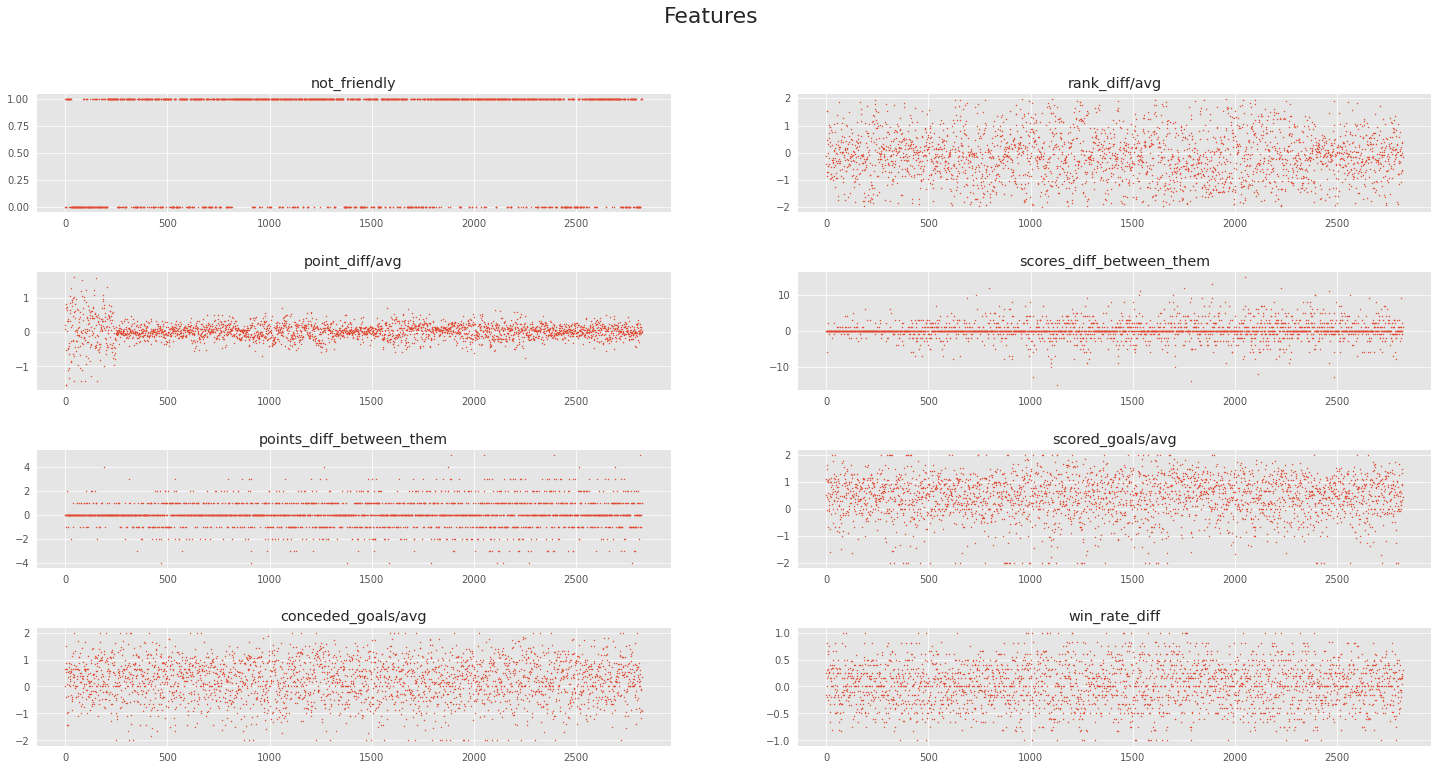

In [26]:
plt.style.use('ggplot')

column_names = df.columns

fig, ax = plt.subplots(4,2, figsize=(25, 12))

ax = ax.flatten()

for i, column_name in enumerate(column_names):
    ax[i].scatter(df.index, df[column_name], s=0.9)
    ax[i].set_title(column_name)

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Features', fontsize=22)
plt.show()

#### Boxplot of Features

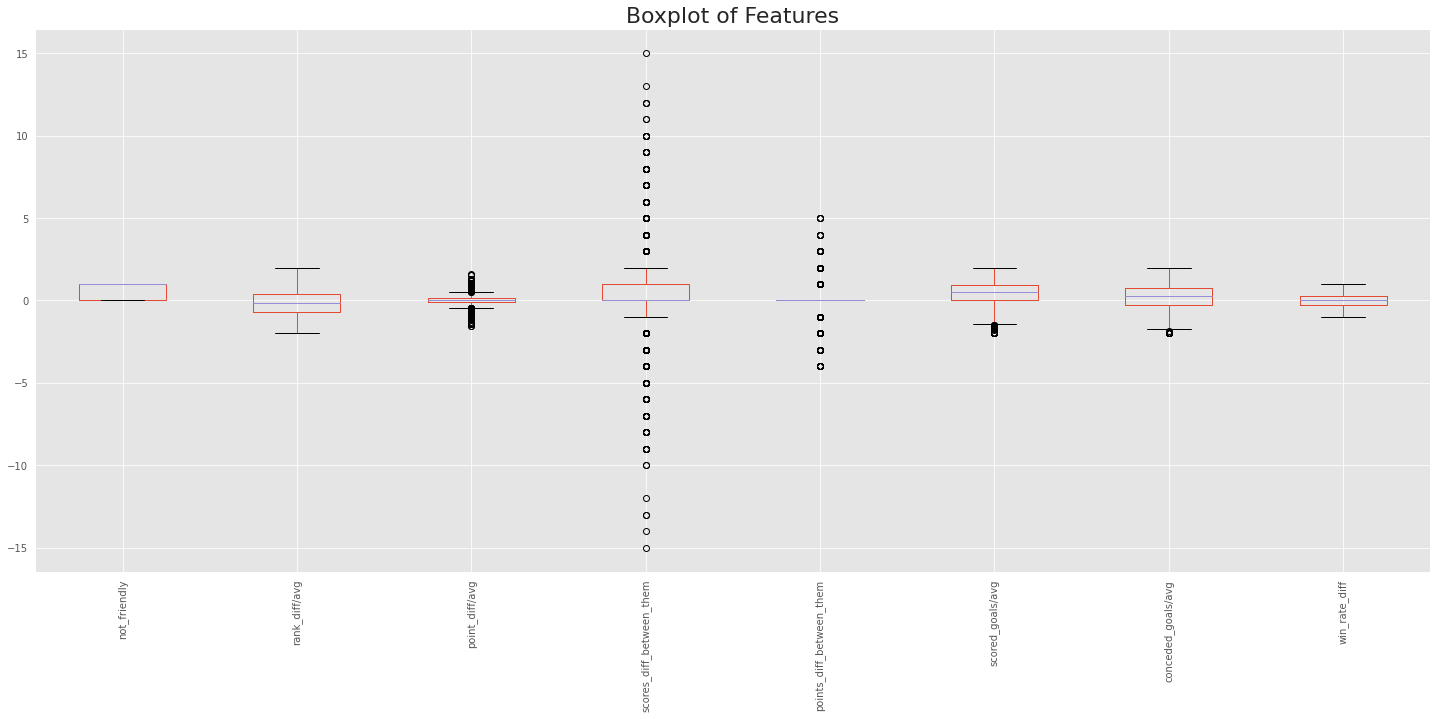

In [27]:
df.boxplot(figsize=(25,10), rot=90)
plt.title('Boxplot of Features', fontsize=22)
plt.show()

#### Pearson Correlation Heatmap

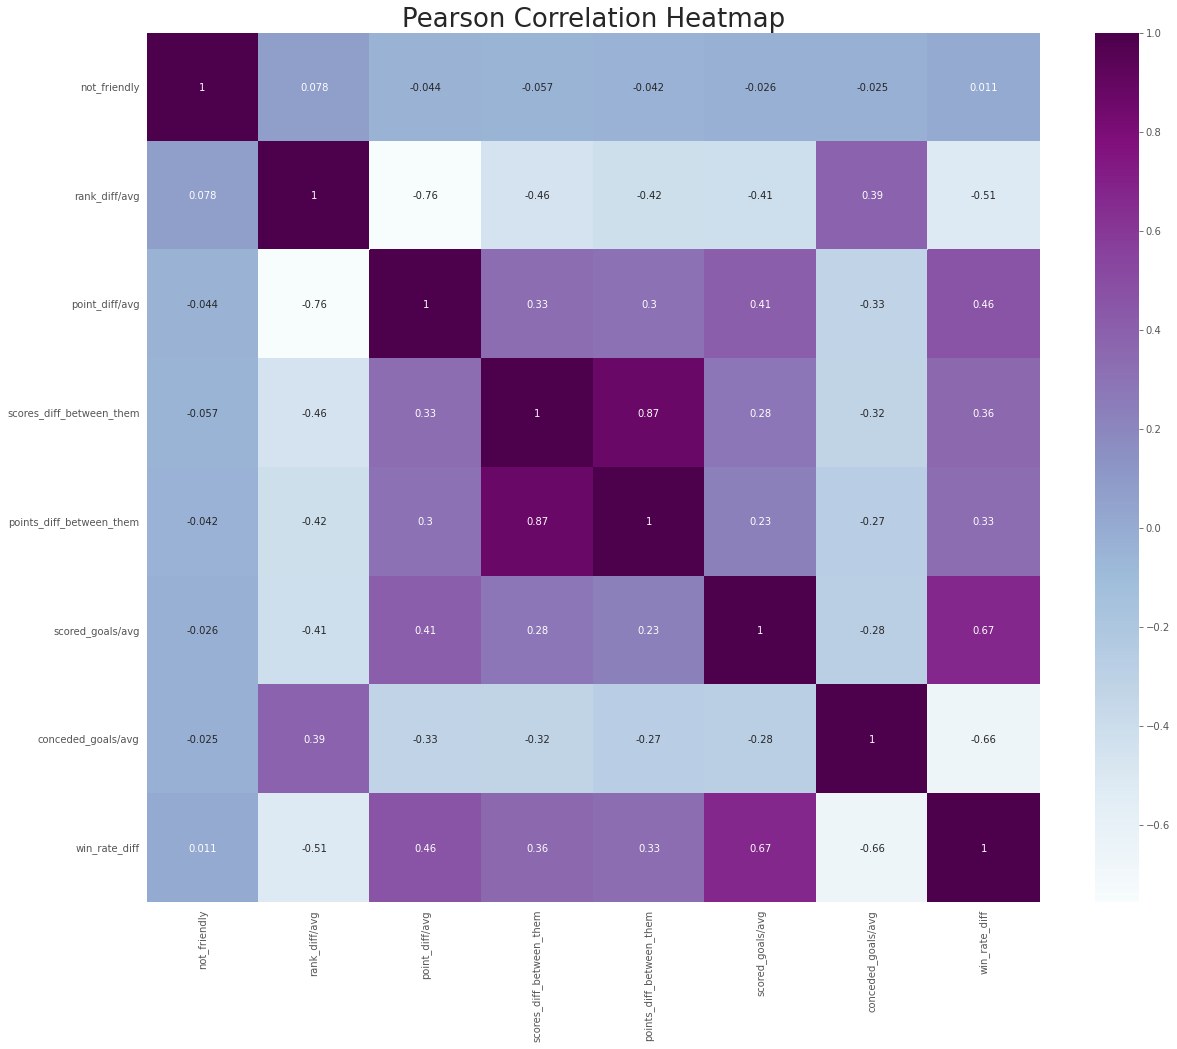

In [28]:
fig, ax = plt.subplots(figsize=(20,16))  
sns.heatmap(df.corr(), annot=True, cmap="BuPu")
plt.title('Pearson Correlation Heatmap', fontsize=26)
plt.show()

#### Looking at the Pearson Correlation Heatmap, we see that the points_diff_between_them and scores_diff_between_them features are very similar to each other. Since there is no need to use the two features together, it will be more efficient for the model to delete one.

#### Considering the boxplot I printed above, it made more sense to discard the scores_diff_between_them feature.

In [29]:
df.drop(['scores_diff_between_them'], inplace=True, axis=1)
X = df
X

,not_friendly,rank_diff/avg,point_diff/avg,points_diff_between_them,scored_goals/avg,conceded_goals/avg,win_rate_diff
0,1,-0.129630,0.218009,0.0,1.111111,0.666667,-0.166631
1,0,-0.400000,0.096328,0.0,0.500000,0.000000,0.249994
2,0,1.521739,-1.530553,0.0,0.434783,0.857143,0.149993
3,0,0.473988,-0.516588,0.0,1.027027,0.545455,0.000000
4,1,-0.848921,0.703297,0.0,1.612903,-0.400000,0.799979
...,...,...,...,...,...,...,...
2816,1,-0.666667,0.075875,-1.0,0.333333,-0.086957,0.149998
2817,1,-0.647482,0.149026,-1.0,1.333333,-1.172414,0.233328
2818,1,0.360656,-0.040130,0.0,0.871795,-0.133333,0.199996
2819,1,-0.018692,0.002859,1.0,1.454545,0.352941,0.166669


## 5) Model Selection

Model selection for classification is the process of choosing the best model to predict the class of an object based on a set of features. It involves comparing different models, typically using metrics such as accuracy, precision, recall, and F1 score, and choosing the one that performs the best on the given dataset. It is a crucial step in the process of building a successful machine learning model as it can have a significant impact on the performance of the final model.

#### Here I extracted the results of all classification models on the dataset with the help of the lazypredict library.


In [30]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 10)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

models

100%|██████████| 29/29 [00:04<00:00,  7.22it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.80,0.76,0.76,0.79,0.27
NuSVC,0.79,0.76,0.76,0.79,0.33
LinearSVC,0.79,0.76,0.76,0.78,0.16
CalibratedClassifierCV,0.79,0.76,0.76,0.78,0.46
RidgeClassifierCV,0.79,0.75,0.75,0.78,0.04
RidgeClassifier,0.79,0.75,0.75,0.78,0.02
LogisticRegression,0.79,0.75,0.75,0.78,0.03
RandomForestClassifier,0.78,0.75,0.75,0.78,0.51
LinearDiscriminantAnalysis,0.79,0.75,0.75,0.78,0.06


#### Machine Learning Model Performances

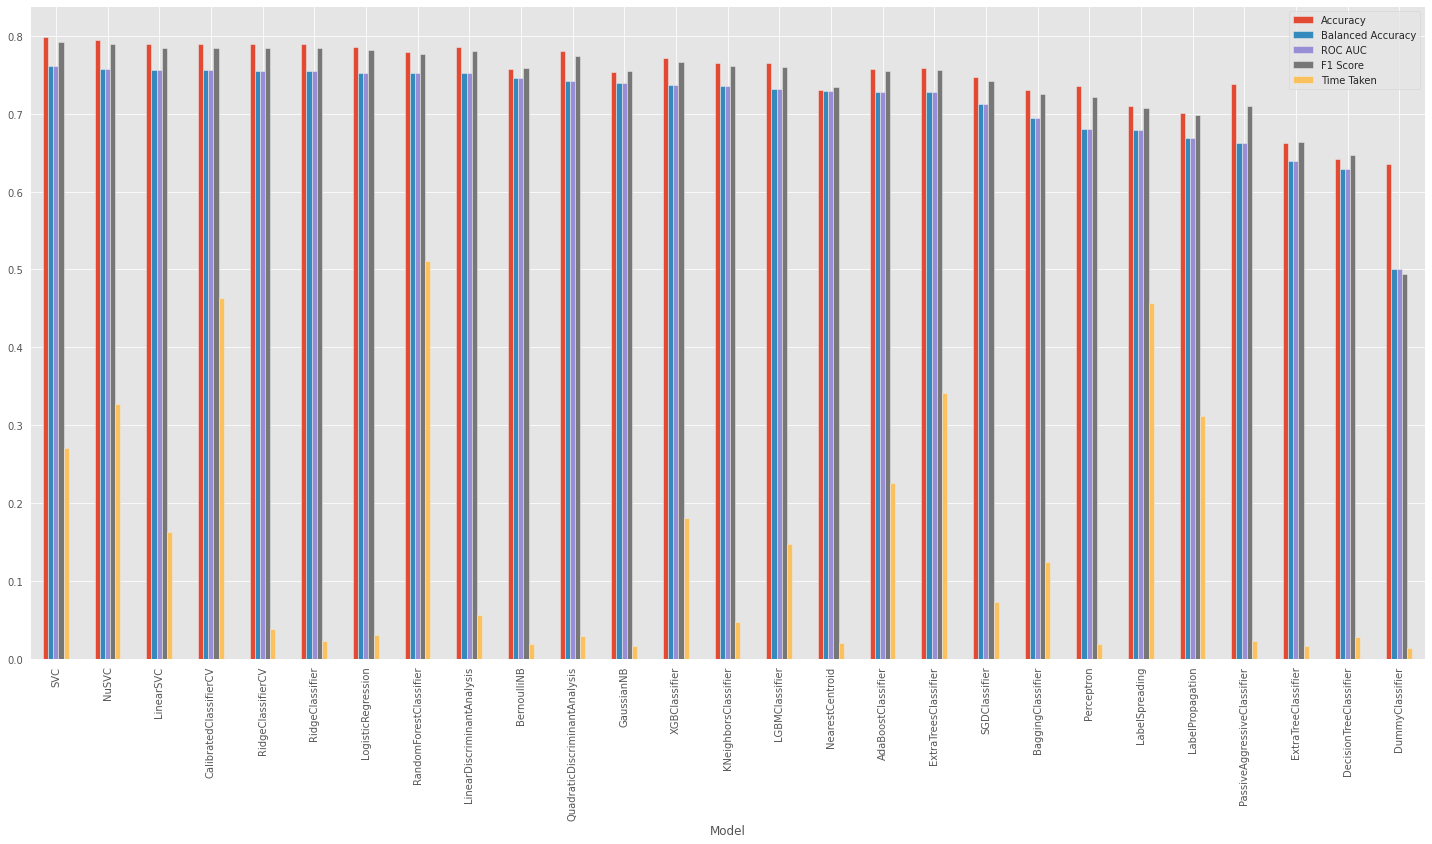

In [31]:
models.plot.bar(figsize=(25,12), rot=90)

#### Function I wrote to visualize model results

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

def predict_and_show_charts(model, name):
    
    # Fit the model
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    # Print train and test accuracy
    
    print('Accuracy of ' + name + ' on training set: {:.2f}'.format(model.score(X_train, y_train)))
    print('Accuracy of ' + name + ' on test set: {:.2f}'.format(model.score(X_test, y_test)) + "\n")
    
    # Plot confusion matrix 
    
    cm = confusion_matrix(y_test, pred)

    plt.figure(figsize=(12,10))
    
    sentiment_classes = ['Home', 'Away']
    ax = sns.heatmap(cm, cmap = plt.cm.Greys, annot = True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title(name + ' Confusion Matrix\n', fontsize=14)
    plt.xlabel('\nTrue Label', fontsize=12)
    plt.ylabel('Predicted Label\n', fontsize=12)
    plt.show()
    
    
    # Plot ROC & Precision-Recall Curve

    Y_test_probs = model.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, Y_test_probs, title = "\n\n" + name + " ROC Curve", figsize=(12,6))
    skplt.metrics.plot_precision_recall(y_test, Y_test_probs, title = "\n\n" + name + " Precision-Recall Curve", figsize=(12,6))
    
    # return test accuracy scores to compare classifications
    
    return model.score(X_test, y_test)

#### SVC seems to be the highest model, but I need probability in the model I use because I will predict the draw in the group stages, so I used the Logistic Regression model with the highest score that provides this.

### Logistic Regression

Accuracy of Logistic Regression Classifier on training set: 0.76
Accuracy of Logistic Regression Classifier on test set: 0.79



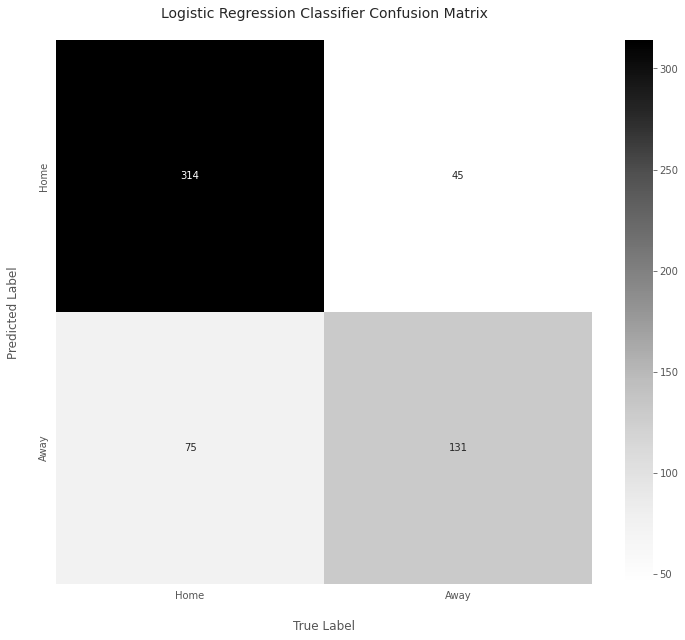

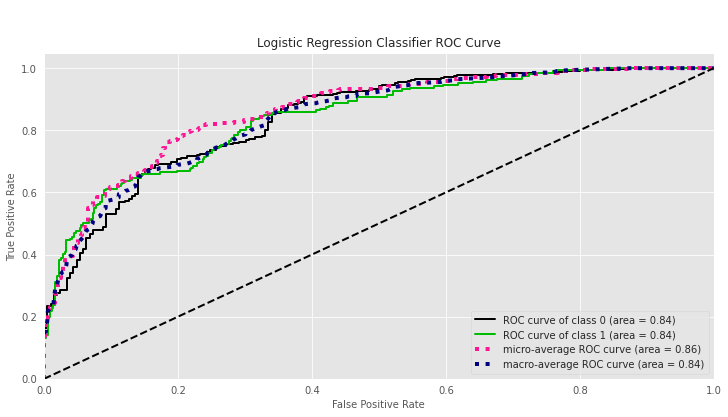

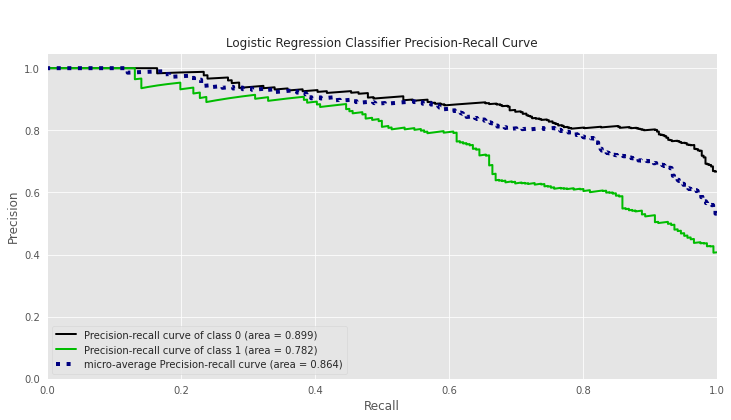

In [33]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg_score = predict_and_show_charts(logreg, "Logistic Regression Classifier")

#### Additionally I tried MLP Classifier, which is a simple neural network model. Although its accuracy is very close, it is one point behind Logistic Regression. I got similar results when I made the world cup predictions with MLP as well. 

### Deep Learning Model: MLP Classifier


Accuracy of Multi-layer Perceptron Classifier on training set: 0.78
Accuracy of Multi-layer Perceptron Classifier on test set: 0.79



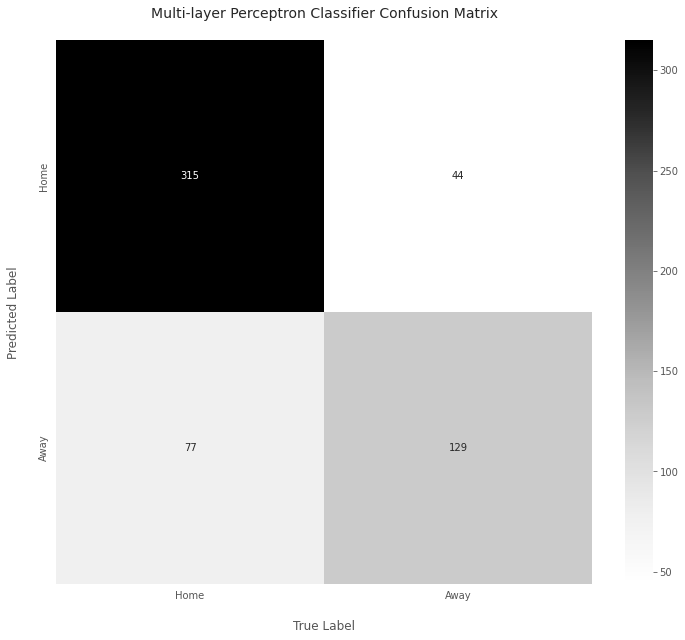

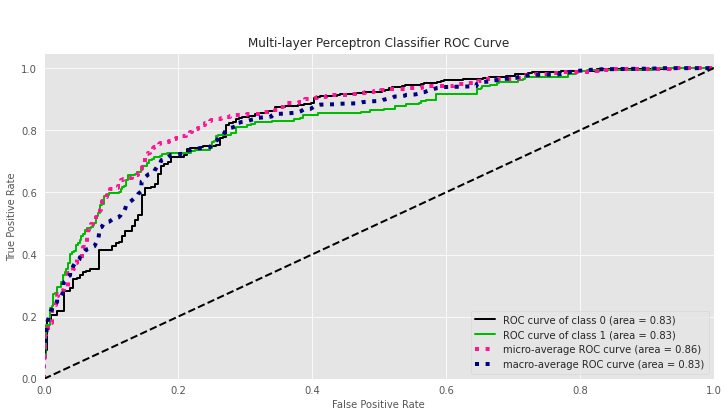

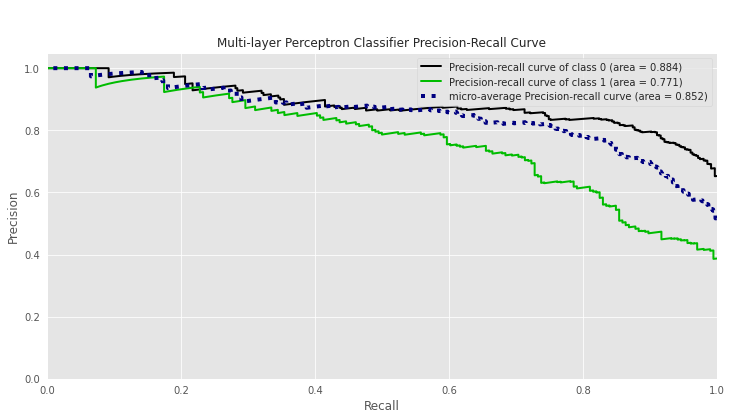

In [34]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp_score = predict_and_show_charts(mlp, "Multi-layer Perceptron Classifier")

## 6) Test Model on World Cup 2022

Finally, I need to apply the model I chose for the world cup results, but first of all, I need to adapt the features I use for the model to the test data. For this, I do a series of operations in order.

In [35]:
# for draw
margin = 0.15

# define the rankings at the time of the World Cup
world_cup_rankings = rank.loc[(rank['rank_date'] == rank['rank_date'].max()) & 
                                    rank['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

wins = []
draws = []

world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in set(world_cup['Group']):

    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        row = pd.DataFrame(np.array([[True, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]]), columns=X_test.columns)

        # point difference/average and rank difference/average

        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'total_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'total_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['average_point'] = (home_points + opp_points) / 2
        row['rank_diff/avg'] = row['rank_difference'] / row['average_rank']
        row['point_diff/avg'] = row['point_difference'] / row['average_point']
        row.drop(['rank_difference', 'average_rank', 'point_difference', 'average_point'], inplace=True, axis=1)

        # point difference between matches played among themselves

        home_games = df_for_test[(df_for_test['home_team'] == home) & (df_for_test['away_team'] == away)].tail(5)
        home_points_home = len(home_games[(home_games['winning_team'] == 1)])
        away_points_home = len(home_games[(home_games['winning_team'] == 2)])
        away_games = df_for_test[(df_for_test['home_team'] == away) & (df_for_test['away_team'] == home_team)].tail(5)
        home_points_away = len(away_games[(away_games['winning_team'] == 2)])
        away_points_away = len(away_games[(away_games['winning_team'] == 1)])

        home_points = home_points_home + home_points_away
        away_points = away_points_home + away_points_away
        row['points_diff_between_them'] = home_points - away_points


        # win rate difference

        home_games_win_rate = df_for_test_2[(df_for_test_2['home_team'] == home) | (df_for_test_2['away_team'] == home)].tail(1)
        if home_games_win_rate['home_team'].values == home:
            home_rate = home_games_win_rate['home_win_rate']
        else:
            home_rate = home_games_win_rate['away_win_rate']
        home_rate = home_rate.values[0]
        
        away_games_win_rate = df_for_test_2[(df_for_test_2['home_team'] == away) | (df_for_test_2['away_team'] == away)].tail(1)

        if away_games_win_rate['home_team'].values == away:
            away_rate = away_games_win_rate['home_win_rate']
        else:
            away_rate = away_games_win_rate['away_win_rate']
          
        away_rate = away_rate.values[0]

        row['win_rate_diff'] = home_rate - away_rate


        # scored goals/average and conceded goals/average

        home_goals, home_opp_goals, away_goals, away_opp_goals = 0, 0, 0, 0

        home_games = df_for_test_2[(df_for_test_2['home_team'] == home)].tail(3)
        home_wins += len(home_games[(home_games['winning_team'] == 1)])
        home_opp_wins += len(home_games[(home_games['winning_team'] == 2)])
        home_goals += home_games['home_score'].sum()
        home_opp_goals += home_games['away_score'].sum()

        home_games = df_for_test_2[(df_for_test_2['away_team'] == home)].tail(3)
        home_wins += len(home_games[(home_games['winning_team'] == 2)])
        home_opp_wins += len(home_games[(home_games['winning_team'] == 1)])
        home_goals += home_games['away_score'].sum()
        home_opp_goals += home_games['home_score'].sum()

        away_games = df_for_test_2[(df_for_test_2['home_team'] == away)].tail(3)
        away_wins += len(away_games[(away_games['winning_team'] == 1)])
        away_opp_wins += len(away_games[(away_games['winning_team'] == 2)])
        away_goals += away_games['home_score'].sum()
        away_opp_goals += away_games['away_score'].sum()

        away_games = df_for_test_2[(df_for_test_2['away_team'] == away)].tail(3)
        away_wins += len(away_games[(away_games['winning_team'] == 2)])
        away_opp_wins += len(away_games[(away_games['winning_team'] == 1)])
        away_goals += away_games['away_score'].sum()
        away_opp_goals += away_games['home_score'].sum()

        row['scored_goals/avg'] = (home_goals - away_goals) / ((home_goals + away_goals) / 2)
        row['conceded_goals/avg'] = (home_opp_goals - away_opp_goals) / ((home_opp_goals + away_opp_goals) / 2)

        #prediction

        home_win_prob = logreg.predict_proba(row)[0][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob

        points = 0
        
        if home_win_prob <= 0.5 - margin:
            world_cup.loc[away, 'points'] += 3
            wins.append(away)

        if home_win_prob > 0.5 - margin:
            points = 1

        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            wins.append(home)

        if points == 1:
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1
            draws.append(home)
            draws.append(away)

#### Visualize Group Results

In [36]:
def get_table(groupArray):
    groupTable = []
    for Team in groupArray:
        newArray = [Team, 0, 0, 0, 0]
      
        for winTeam in wins:
            if winTeam == Team:
                newArray[1] += 1
        
        for drawTeam in draws:
            if drawTeam == Team:
                newArray[2] += 1
        
        newArray[3] = 3-(newArray[1]+newArray[2])
        newArray[4] = 3*newArray[1]+newArray[2]
        
        groupTable.append(newArray)
    groupTable.sort(key = lambda groupTable: groupTable[4], reverse = True)
    groupTable.insert(0, ['Team Name', 'Wins', 'Draws', 'Losses', 'Points', 'Advanced to Group Stage?'])
    return groupTable

groups = {'Group A': ['Qatar', 'Ecuador', 'Senegal', 'Netherlands'],
          'Group B': ['England', 'Iran', 'USA', 'Wales'],
          'Group C': ['Argentina', 'Saudi Arabia', 'Mexico', 'Poland'],
          'Group D' : ['France', 'Australia', 'Denmark', 'Tunisia'],
          'Group E' : ['Spain', 'Germany', 'Japan', 'Costa Rica'],
          'Group F' : ['Belgium', 'Canada', 'Morocco', 'Croatia'],
          'Group G' : ['Brazil', 'Serbia', 'Switzerland', 'Cameroon'],
          'Group H' : ['Portugal', 'Ghana', 'Uruguay', 'Korea Republic'],
}
newerArray = []
count = 0
for x in groups:
    newerArray.append(get_table(groups[x]))
    print(x)
    print(tabulate(newerArray[count], headers='firstrow', tablefmt='fancy_grid'), '\n')
    count += 1

Group A
╒═════════════╤════════╤═════════╤══════════╤══════════╕
│ Team Name   │   Wins │   Draws │   Losses │   Points │
╞═════════════╪════════╪═════════╪══════════╪══════════╡
│ Senegal     │      2 │       1 │        0 │        7 │
├─────────────┼────────┼─────────┼──────────┼──────────┤
│ Netherlands │      2 │       1 │        0 │        7 │
├─────────────┼────────┼─────────┼──────────┼──────────┤
│ Qatar       │      0 │       1 │        2 │        1 │
├─────────────┼────────┼─────────┼──────────┼──────────┤
│ Ecuador     │      0 │       1 │        2 │        1 │
╘═════════════╧════════╧═════════╧══════════╧══════════╛ 

Group B
╒═════════════╤════════╤═════════╤══════════╤══════════╕
│ Team Name   │   Wins │   Draws │   Losses │   Points │
╞═════════════╪════════╪═════════╪══════════╪══════════╡
│ England     │      3 │       0 │        0 │        9 │
├─────────────┼────────┼─────────┼──────────┼──────────┤
│ USA         │      1 │       1 │        1 │        4 │
├────────────

#### According to the model results of the teams that qualify from the groups, the chances of promotion to the next rounds and their matches

#### Matches of teams coming out of the groups are correctly adjusted for World Cup 2022 tournament bracket

In [39]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[True, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]]), columns=X_test.columns)

        # point difference/average and rank difference/average

        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'total_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'total_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        row['average_point'] = (home_points + opp_points) / 2
        row['rank_diff/avg'] = row['rank_difference'] / row['average_rank']
        row['point_diff/avg'] = row['point_difference'] / row['average_point']
        row.drop(['rank_difference', 'average_rank', 'point_difference', 'average_point'], inplace=True, axis=1)

        # point difference between matches played among themselves

        home_games = df_for_test[(df_for_test['home_team'] == home) & (df_for_test['away_team'] == away)].tail(5)
        home_points_home = len(home_games[(home_games['winning_team'] == 1)])
        away_points_home = len(home_games[(home_games['winning_team'] == 2)])
        away_games = df_for_test[(df_for_test['home_team'] == away) & (df_for_test['away_team'] == home_team)].tail(5)
        home_points_away = len(away_games[(away_games['winning_team'] == 2)])
        away_points_away = len(away_games[(away_games['winning_team'] == 1)])

        home_points = home_points_home + home_points_away
        away_points = away_points_home + away_points_away
        row['points_diff_between_them'] = home_points - away_points


        # win rate difference

        home_games_win_rate = df_for_test_2[(df_for_test_2['home_team'] == home) | (df_for_test_2['away_team'] == home)].tail(1)
        if home_games_win_rate['home_team'].values == home:
            home_rate = home_games_win_rate['home_win_rate']
        else:
            home_rate = home_games_win_rate['away_win_rate']
        home_rate = home_rate.values[0]
        
        away_games_win_rate = df_for_test_2[(df_for_test_2['home_team'] == away) | (df_for_test_2['away_team'] == away)].tail(1)

        if away_games_win_rate['home_team'].values == away:
            away_rate = away_games_win_rate['home_win_rate']
        else:
            away_rate = away_games_win_rate['away_win_rate']
          
        away_rate = away_rate.values[0]

        row['win_rate_diff'] = home_rate - away_rate

        # scored goals/average and conceded goals/average

        home_goals, home_opp_goals, away_goals, away_opp_goals = 0, 0, 0, 0

        home_games = df_for_test_2[(df_for_test_2['home_team'] == home)].tail(3)
        home_wins += len(home_games[(home_games['winning_team'] == 1)])
        home_opp_wins += len(home_games[(home_games['winning_team'] == 2)])
        home_goals += home_games['home_score'].sum()
        home_opp_goals += home_games['away_score'].sum()
        home_goals += home_games['home_score'].sum()
        home_opp_goals += home_games['away_score'].sum()

        home_games = df_for_test_2[(df_for_test_2['away_team'] == home)].tail(3)
        home_wins += len(home_games[(home_games['winning_team'] == 2)])
        home_opp_wins += len(home_games[(home_games['winning_team'] == 1)])
        home_goals += home_games['away_score'].sum()
        home_opp_goals += home_games['home_score'].sum()

        away_games = df_for_test_2[(df_for_test_2['home_team'] == away)].tail(3)
        away_wins += len(away_games[(away_games['winning_team'] == 1)])
        away_opp_wins += len(away_games[(away_games['winning_team'] == 2)])
        away_goals += away_games['home_score'].sum()
        away_opp_goals += away_games['away_score'].sum()

        away_games = df_for_test_2[(df_for_test_2['away_team'] == away)].tail(3)
        away_wins += len(away_games[(away_games['winning_team'] == 2)])
        away_opp_wins += len(away_games[(away_games['winning_team'] == 1)])
        away_goals += away_games['away_score'].sum()
        away_opp_goals += away_games['home_score'].sum()

        row['scored_goals/avg'] = (home_goals - away_goals) / ((home_goals + away_goals) / 2)
        row['conceded_goals/avg'] = (home_opp_goals - away_opp_goals) / ((home_opp_goals + away_opp_goals) / 2)

        #prediction

        home_win_prob = logreg.predict_proba(row)[0][0]
        if logreg.predict_proba(row)[0][0] < 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Netherlands vs. USA: Netherlands wins with probability 0.71
Argentina vs. Denmark: Argentina wins with probability 0.92
Spain vs. Croatia: Spain wins with probability 0.75
Brazil vs. Uruguay: Brazil wins with probability 0.95
Senegal vs. England: England wins with probability 0.58
Mexico vs. France: France wins with probability 0.69
Germany vs. Belgium: Belgium wins with probability 0.76
Serbia vs. Portugal: Portugal wins with probability 0.66


___Starting of the quarterfinal___
Netherlands vs. Argentina: Argentina wins with probability 0.77
Spain vs. Brazil: Brazil wins with probability 0.89
England vs. France: England wins with probability 0.51
Belgium vs. Portugal: Belgium wins with probability 0.85


___Starting of the semifinal___
Argentina vs. Brazil: Brazil wins with probability 0.66
England vs. Belgium: Belgium wins with probability 0.73


___Starting of the final___
Brazil vs. Belgium: Brazil wins with probability 0.86




#### Visualization of Road To Final

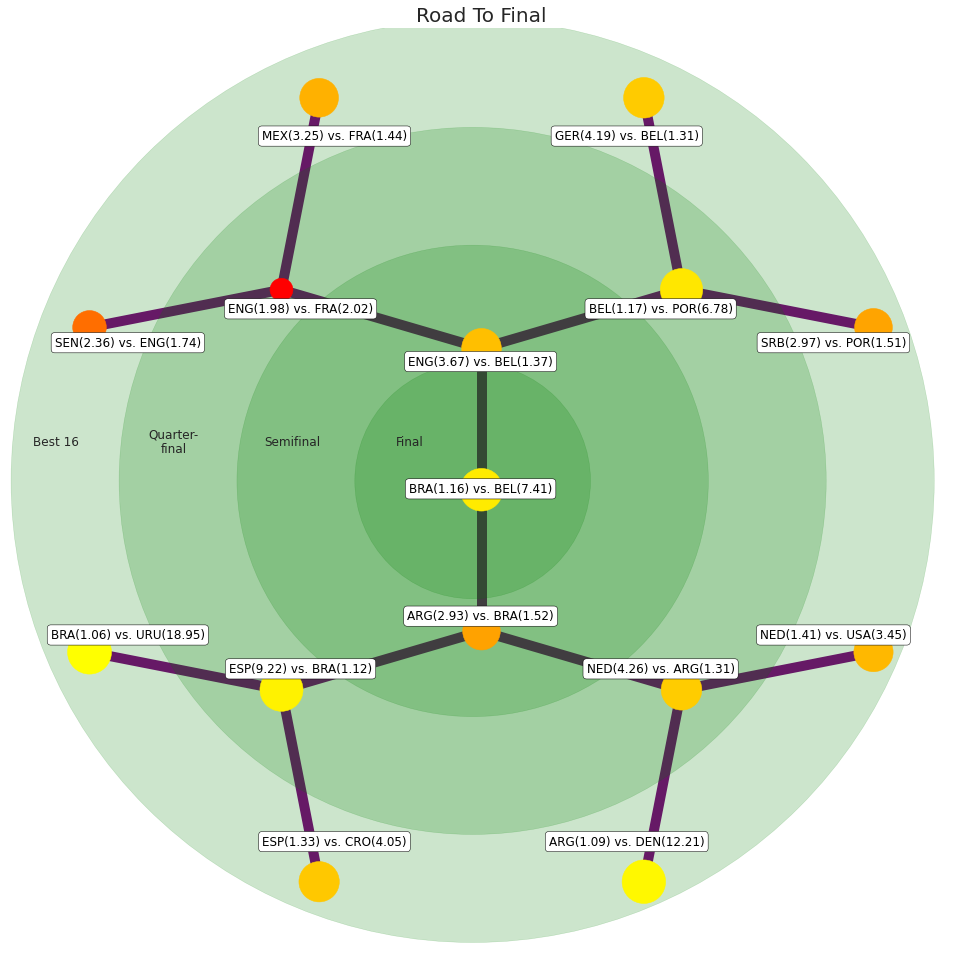

In [40]:
next_round_wc = world_cup.groupby('Group').nth([0, 1]) 
teams_through = next_round_wc['Team']


node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(17,17))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='green', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='autumn',
        edge_color='purple',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Road To Final', fontsize=20)
plt.show()

## Conclusion

This project aimed to predict the winner of the 2022 World Cup using various classification techniques, and feature extraction methods. Two datasets were used: one containing match scores from 1982 to the present and the other containing FIFA rank changes. Various classification techniques such as logistic regression, decision trees, neural networks, and feature extraction to analyze the data and make predictions.

After comparing the performance of the different models using evaluation metrics such as accuracy, precision, recall, and F1 score, it was found that linear regression performed the best. The model was fine-tuned and used to make predictions for the tournament.

The results of this study demonstrate the potential of advanced machine learning techniques in predicting the outcome of sports events. By analyzing historical data, valuable insights were gained into the performance of different teams and the factors that contribute to their success. Linear regression was found to be the best-suited model for the task and it showed good performance.

I also got very similar results with MLP Classifier. This is actually an indication that advanced deep learning models can be more successful than traditional machine learning models for match result predictions.

It is important to note that the predictions made in this study are based on historical data and are subject to uncertainty. The tournament could be influenced by many unforeseen factors such as injuries, team dynamics, and weather conditions. Additionally, the results of this study are limited by the quality and completeness of the data used. The datasets used in this study only contain information about the match scores and FIFA rank changes, and do not take into account other important factors such as injuries, team dynamics, and weather conditions.

Despite these limitations, this study serves as a valuable starting point for future research on predicting the outcome of sports events using machine learning and deep learning techniques.

### References

* [1] https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017
* [2] https://www.kaggle.com/datasets/cashncarry/fifaworldranking